# Rag From Scratch: Retrieval

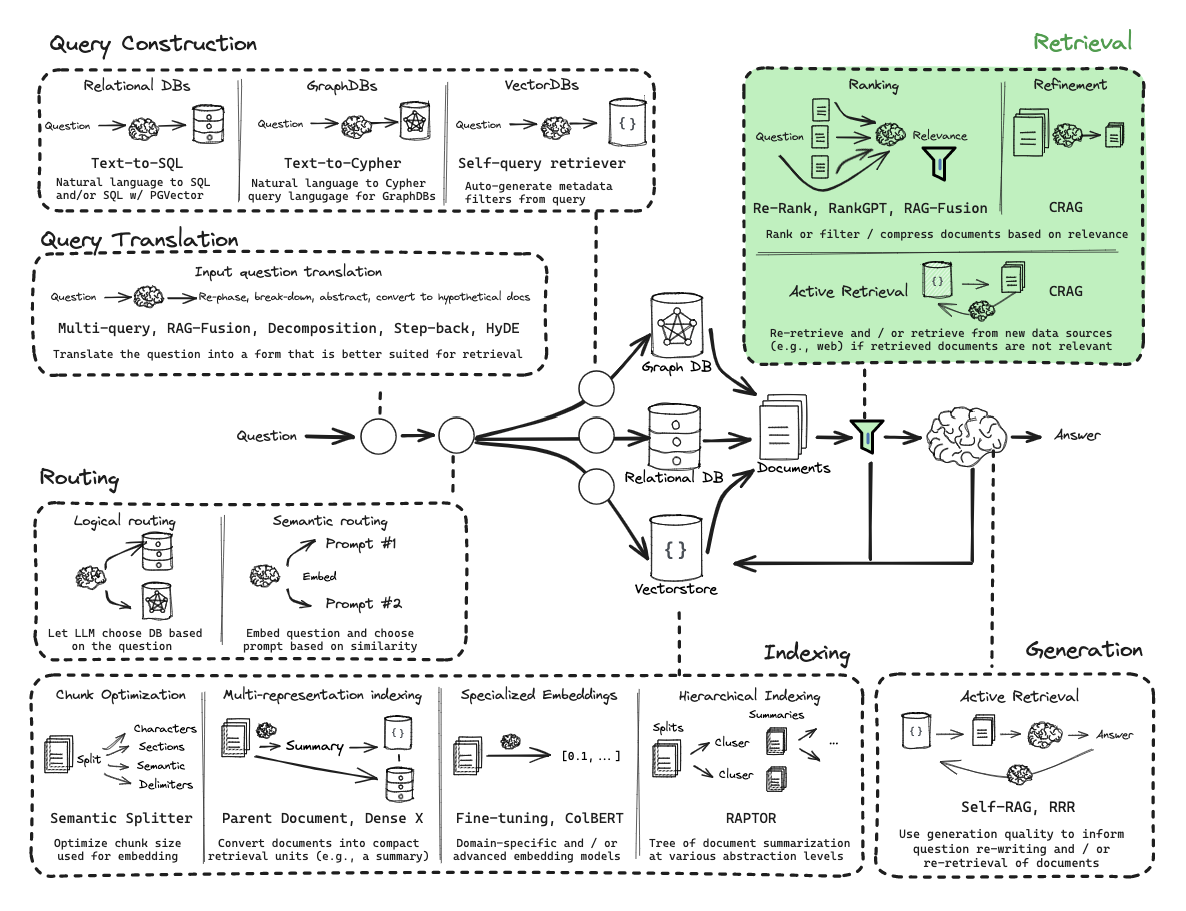

## Enviornment

`(1) Packages`

In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain cohere

`(2) LangSmith`

https://docs.smith.langchain.com/

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

`(3) API Keys`

In [ ]:
os.environ['OPENAI_API_KEY'] = <your-api-key>
os.environ['COHERE_API_KEY'] = <your-api-key>

## Part 15: Re-ranking

We showed this previously with RAG-fusion.

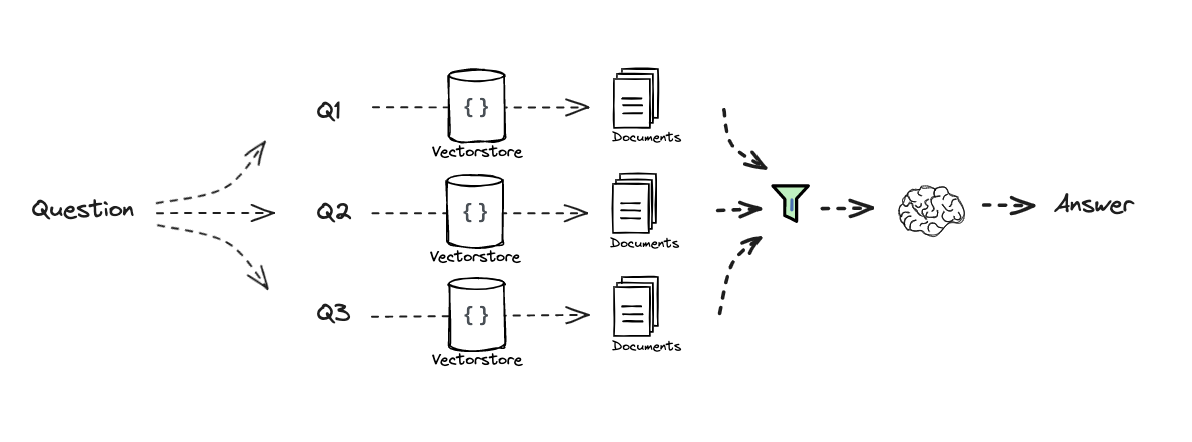

In [29]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_openai import OpenAIEmbeddings
# from langchain_cohere import CohereEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    # embedding=CohereEmbeddings()
                                    embedding=OpenAIEmbeddings())


retriever = vectorstore.as_retriever()

In [2]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [3]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [5]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

question = "What is task decomposition for LLM agents?"
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

/Users/rlm/miniforge3/envs/llama2/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:86: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


7

In [9]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals. This enables the agent to efficiently handle complex tasks by dividing them into smaller and simpler steps. Task decomposition can be achieved through techniques like Chain of Thought (CoT) and Tree of Thoughts, which prompt the model to think step by step and explore multiple reasoning possibilities at each step. Additionally, task decomposition can be done using simple prompting, task-specific instructions, or with human inputs.'

We can also use [Cohere Re-Rank](https://python.langchain.com/docs/integrations/retrievers/cohere-reranker#doing-reranking-with-coherererank). 

See [here](https://txt.cohere.com/rerank/):

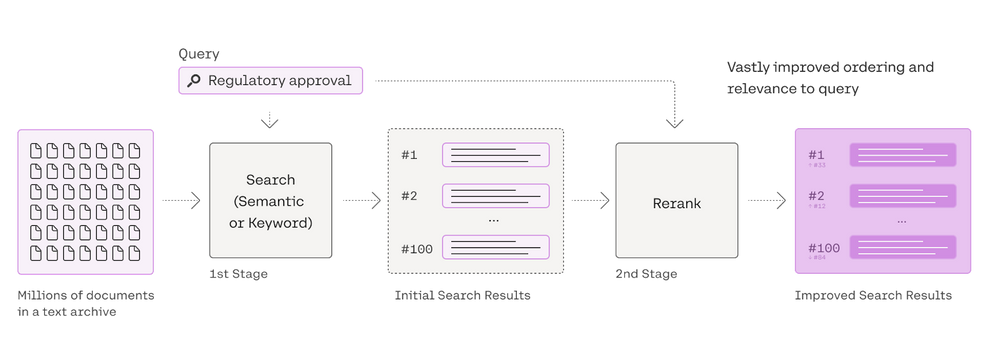

In [4]:
from langchain_community.llms import Cohere
from langchain.retrievers import  ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank

In [25]:
from langchain.retrievers.document_compressors import CohereRerank

retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

# Re-rank
compressor = CohereRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

compressed_docs = compression_retriever.get_relevant_documents(question)

## 16 - Retrieval (CRAG)

`Deep Dive`

https://www.youtube.com/watch?v=E2shqsYwxck

`Notebooks`

https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_crag.ipynb

https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_crag_mistral.ipynb

# Generation



## 17 - Retrieval (Self-RAG)
 
`Notebooks`

https://github.com/langchain-ai/langgraph/tree/main/examples/rag

https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_self_rag_mistral_nomic.ipynb

## 18 - Impact of long context  

`Deep dive`

https://www.youtube.com/watch?v=SsHUNfhF32s

`Slides`

https://docs.google.com/presentation/d/1mJUiPBdtf58NfuSEQ7pVSEQ2Oqmek7F1i4gBwR6JDss/edit#slide=id.g26c0cb8dc66_0_0